In [2]:
import pandas as pd
import pickle
import pydot
from keras.layers import RepeatVector,Dense,Embedding,LSTM,TimeDistributed,concatenate,Activation,Dropout,Input,SpatialDropout1D,Bidirectional,BatchNormalization
from keras.models import Sequential,Model
from keras.utils import plot_model
from keras.optimizers import RMSprop
from ImageCaption import build_vocab,max_sequence,data_generator
from keras.preprocessing import sequence,image
from keras.applications.resnet50 import preprocess_input,ResNet50
from keras import backend
from IPython.display import Image,display
from pathlib import Path
import numpy as np
from nltk.translate.bleu_score import corpus_bleu

In [3]:
with open("features.pickle","rb") as fpickle:
    encoded_img=pickle.load(fpickle)

In [4]:
dataset=pd.read_csv("Flickr8k/captions/train_dataset.txt",delimiter="\t")#read training dataset file
pd_frame=dataset.values
print(pd_frame.shape)

(30000, 2)


In [5]:
sentences=[]
for sent in range(pd_frame.shape[0]):
    sentence=pd_frame[sent][1]
    sentences.append(sentence)#append all the sentences in a list
len(sentences)    

30000

In [6]:
vocabulary,clean_desc=build_vocab(sentences,1)
vocab_size=len(vocabulary)+1
vocab_size

7669

In [7]:
total_count=sum([len(word.split())-1 for word in clean_desc])#total count of words
total_count

383266

In [8]:
#vectorization
word2id={value:index for index,value in enumerate(vocabulary)}
id2word={index:value for index,value in enumerate(vocabulary)}

word2id[id2word.get(0)]=7668
word2id["PAD"]=0

id2word[7668]=id2word.get(0)
id2word[0]="PAD"

len(list(word2id.keys()))

7669

In [9]:
#fix values for model training
embedding_size=300
max_length=max_sequence(clean_desc)
batch_size=180
steps=total_count/batch_size
steps

2129.2555555555555

In [10]:
def create_model(embedding_size,max_len,vocab_size):
    #image encoder
    input1=Input(shape=(2048,))
    image2=Dense(embedding_size, activation='relu')(input1)
    image3=RepeatVector(max_len)(image2)
    
    #text encoder
    input2=Input(shape=(max_len,))
    emb=Embedding(vocab_size, embedding_size)(input2)
    l1=LSTM(256,return_sequences=True)(emb)
    td=TimeDistributed(Dense(embedding_size))

    
    #decoder
    conc=concatenate([image3,l1])
    x=LSTM(512,return_sequences=True)(conc)
    x=LSTM(512,return_sequences=False)(x)
    x = Dense(vocab_size)(x)
    out = Activation('softmax')(x)
    model = Model(inputs=[input1,input2], outputs = out) 
    model.summary()
    
    model.compile(loss="categorical_crossentropy",optimizer=RMSprop(lr=0.0001) ,metrics=["accuracy"])
    #plot_model(model, to_file='model.png')
    #print(backend.eval(model.optimizer.lr))
    return model




In [11]:
model=create_model(embedding_size,max_length,vocab_size)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          614700      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 39, 300)      2300700     input_2[0][0]                    
_____________________________________

In [ ]:
#model.fit_generator(data_generator(encoded_img,pd_frame,max_length,batch_size,word2id),steps_per_epoch=steps,epochs=5,verbose=1)

In [12]:
model.load_weights("final_weights.h5")

## Prediction 

In [13]:
def preprocessing(path):
    img=image.load_img(path,target_size=(224,224,3))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    return img

In [14]:
def image_encoding(model,image):
    img=preprocessing(image)
    img=image_model.predict(img).reshape(2048,)
    return img

In [15]:
image_model=ResNet50(include_top=False,weights="imagenet",input_shape=(224,224,3),pooling="avg")

In [16]:
#beam search decoding
def BeamSearch(encoded_image,max_seq,k=3):
    complete_sentences=[]
    start_word=[[[word2id["<start>"]],1.0]]   
    while len(start_word[0][0]) < max_seq:
        captions=[]
        for i in start_word:
            padded_seq=sequence.pad_sequences([i[0]],maxlen=39,padding="post")
            pred=model.predict([np.array([encoded_image]), np.array(padded_seq)])[0]
            
            #keep top k word indices
            word_index = pred.argsort()[-k:]
        
            for word in word_index:
                partial_cap,prob=i[0][:],i[1]
                partial_cap.append(word)
                prob=prob+pred[word]   
                captions.append([partial_cap,prob])
                
            
        #sort and keep the first k partial captions
        start_word=sorted(captions,key=lambda x:x[1])
        start_word=start_word[-k:]
        
        #search for <end> tag in top 3 partial captions
        for sublist in start_word:
            if word2id["<end>"] in sublist[0]:
                return " ".join([id2word[word] for word in sublist[0]][1:-1])
                    
    final_caption=[id2word[idx] for idx in start_word[-1][0] if idx!=word2id["<end>"]]
    final_caption=" ".join(final_caption[1:])
    return final_caption
            

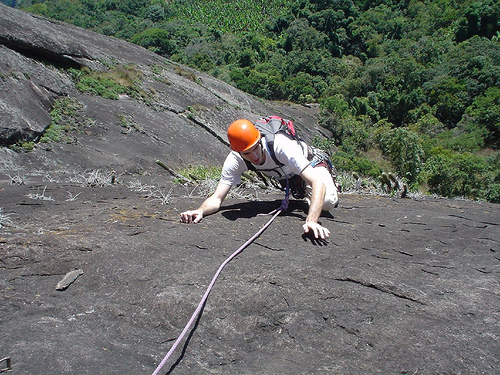

'a man wearing a harness climbs a rock face .'

In [17]:
img_path=Path("Flickr8k/Flicker8k_Dataset/140377584_12bdbdf2f8.jpg")
test_img=image_encoding(image_model, img_path)
img=Image(img_path)
display(img)
BeamSearch(test_img,15)

## Bleu Score

In [18]:
def CalculateBleu(test_path):
    reference=[]
    candidate=[]
    count=0
    with open(test_path) as file:
        test_set=file.read().split("\n")
        
    #candidate list
    for img in range(1,len(test_set)-1,5):
        count+=1
        image=test_set[img].split("\t")[0]
        test_img=encoded_image[image]
        pred=BeamSearch(test_img,15)
        token=pred.split(" ")
        candidate.append(token)
        
     #reference list   
        temp=[]
        for i in range(5):
            caption=test_set[i+img].split("\t")[1]
            tokenize=caption.split(" ")[1:-2]
            temp.append(tokenize)
        reference.append(temp)
    score = corpus_bleu(reference, candidate,weights=(1,0,0,0))
    print(score)      

In [19]:
with open("test_features.pickle","rb") as fpickle:
    encoded_image=pickle.load(fpickle)

In [20]:
test_path="Flickr8k/captions/test_dataset.txt"
CalculateBleu(test_path)

0.4847766290429669